## Predicting Airbnb Listing Price | Plotting

In this notebook I used the `for_plotting.csv` and `df_clean.csv` files to get a better sense for trends in the data using plots.

In [1]:
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as mp

from sqlalchemy import create_engine
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
SEED = 1
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['figure.figsize'] = [50, 50]

In [3]:
directory = '/Users/limesncoconuts2/datasets/airbnb/'
df_plot = pd.read_csv(directory + 'for_plotting.csv')
df = pd.read_csv(directory + 'df_clean.csv', usecols=["zipcode", "id", "longitude", "latitude", "price_USD"])

In [4]:
price = df_plot.price_USD
property_type = df_plot.property_type
accommodates = df_plot.accommodates
square_feet = df_plot.square_feet

### Price

It's important to look into the trends and behavior of the target variable `price_USD`. A histogram of price is right-skewed, meaning that the mean is larger than the median. This makes sense, since most Airbnb listings will target the majority of consumers that are looking for affordable options, and most listings are smaller apartments or individual rooms. On the other hand, larger and more luxurious Airbnbs exist for nice vacations and getaways.

The violin plot and boxplot are additional representations of `price_USD`. There are many outliers on the more expensive end, with more listings being priced between $0 and $200.

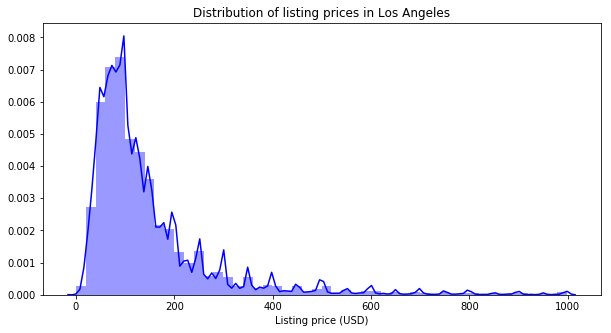

In [5]:
fig, axes = plt.subplots(figsize=(10,5))
ax = sns.distplot(price, color='blue')
plt.xlabel('Listing price (USD)')
plt.title('Distribution of listing prices in Los Angeles')
plt.show()

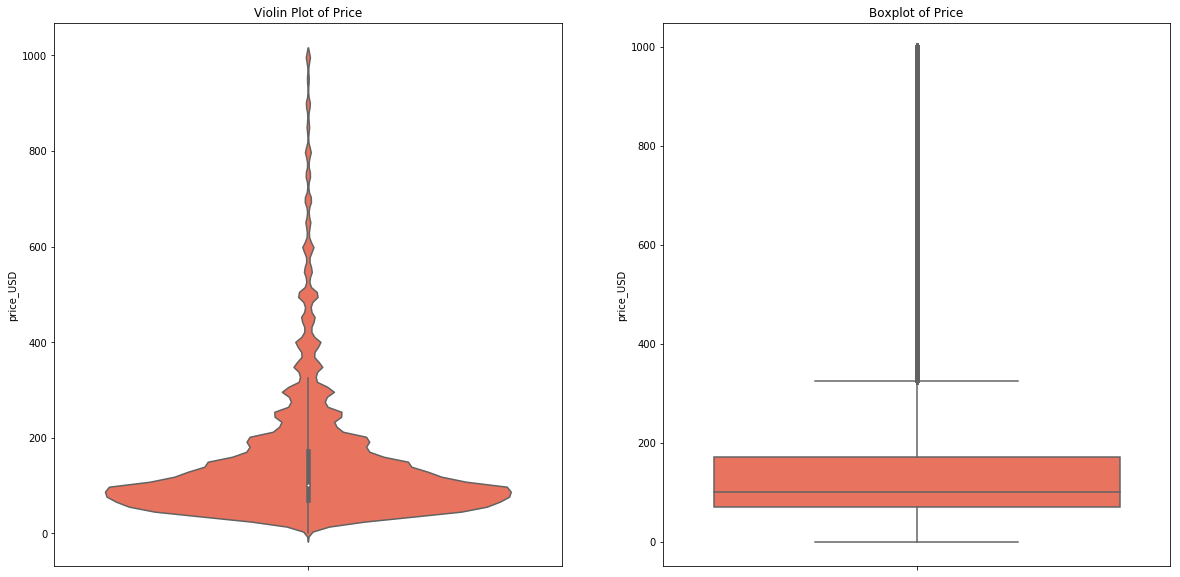

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
ax = sns.violinplot(y=price, ax=axes[0], color="tomato")
ax.set(title="Violin Plot of Price")

ax = sns.boxplot(y=price, ax=axes[1], color="tomato")
ax.set(title="Boxplot of Price")

plt.show()

#### Mapping

I also looked at price geographically by graphing the mean listing price by zip code. I created a GeoDataFrame using a shapefile of Los Angeles zip codes and the Airbnb information. A random selection of the 1.1 million points are plotted to make it possible for human eyes to discriminate the distribution of features on the map.

The code below also shows the creation of a simplified `property_type` feature for mapping purposes. Since most listings are of type "apartment" or "house", every other category was changed to "other" for the map.

In [7]:
listing_df = df[["zipcode", "id", "longitude", "latitude", "price_USD"]]
listing_df["property_type"] = property_type

In [8]:
keep = (listing_df.property_type == 'apartment') | (listing_df.property_type == 'house')
to_other = np.unique(list(listing_df[~keep].property_type))
listing_df.property_type.replace(to_replace=to_other, value='other', inplace=True)
listing_df.property_type = listing_df.property_type.astype('object').astype('category')

In [9]:
la_map = gpd.read_file(directory + "zip-code.geojson")
la_map["name"] = la_map["name"].astype(int)

In [10]:
def create_point(row):
    '''Create a point geometry object from the listing df
        where the longitude is in the 4th position and the
        latitude is in the 5th position.
    '''
    return Point(row[3], row[4])

In [11]:
cores = mp.cpu_count()
with mp.Pool(cores) as pool:
    result = pool.imap(create_point, listing_df.itertuples(name=False), chunksize=10)
    listing_df['point'] = [x for x in result]

In [12]:
listing_df.zipcode = pd.to_numeric(listing_df.zipcode,  errors='coerce')
listing_df = gpd.GeoDataFrame(listing_df, geometry="point")
geo_df = listing_df.groupby("zipcode").count().reset_index()
geo_df = pd.merge(geo_df, la_map, how="left", left_on="zipcode", right_on="name")
geo_df = geo_df.set_index("zipcode")
geo_df = gpd.GeoDataFrame(geo_df)
geo_df = geo_df[geo_df.geometry.notna()]

In [13]:
# map of price distribution
fig, ax = plt.subplots(figsize=(30,30))
base = geo_df.plot(column="price_USD", cmap="Greens", edgecolor="whitesmoke", ax=ax)
geo_df.apply(lambda x: ax.annotate(s=x.external_id,
                                       xy=x.geometry.centroid.coords[0],
                                       ha="center", fontweight="light",
                                       fontsize=12, color="black"), axis=1)
base.axis("off")

min_price = geo_df["price_USD"].min()
max_price = geo_df["price_USD"].max()

ax.set_xlim([-118.6, -118])
ax.set_ylim([33.9, 34.2])

gradient = plt.cm.ScalarMappable(cmap="Greens", norm=plt.Normalize(vmin=min_price, vmax=max_price))
gradient._A = []

cbar = fig.colorbar(gradient, fraction=0.025, pad=.03)
cbar.ax.set_yticklabels(["$" + i.get_text() for i in cbar.ax.get_yticklabels()])

plt.rcParams['axes.titlepad'] = 20 
plt.title("Average Nightly Rate of Airbnb Listings in Los Angeles, CA by Zip Code", fontdict={"fontsize":35})

plt.savefig('average_price_map.png')
plt.close()

<img src='average_price_map.png'> 

The map of mean price shows that the most expensive listings include:
- 90291, Venice
- 90046, Hollywood Hills
- 90026, Silver Lake

These neighborhoods are all wealthy, well located areas near the Los Angeles city center or on the beach. Most of the more expensive listings in general follow this pattern, with those closer to urban areas being more expensive.

### Accomodates

Another interesting variable is `accommodates`, which is the number of people that the Airbnb can hold. It looks like most Airbnbs are for 1 person, with most others being for 2-4 people. This makes sense because most listings are on the inexpensive side, and small listings for 1 person would be some of the least expensive listings on the platform.

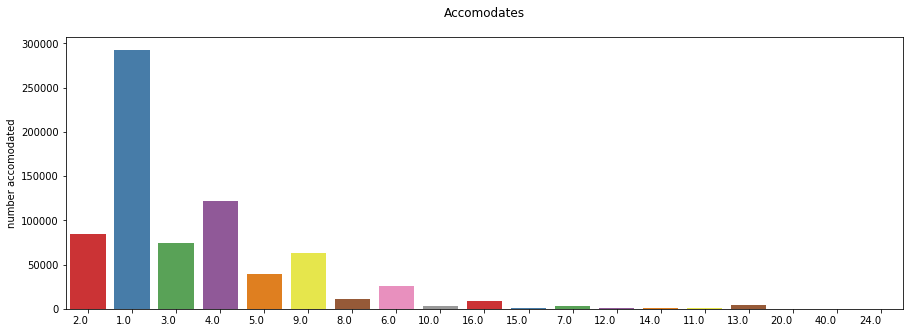

In [14]:
fig, axes = plt.subplots(figsize=(15,5))
ax = sns.countplot(x=accommodates, palette='Set1')
ax.set(title='Accomodates', xlabel='', ylabel='number accomodated')
ax.set_xticklabels(labels=accommodates.unique(), ha='right')
plt.show()

### Square Footage

Square footage is another variable that can be associated with the price of a listing. There is a similar trend in `square_feet` as for `price_USD` where the mean is greater than the median. Since most listings are inexpensive, only accommodate one person, and are in urban areas, it makes sense that most are also on the smaller side.

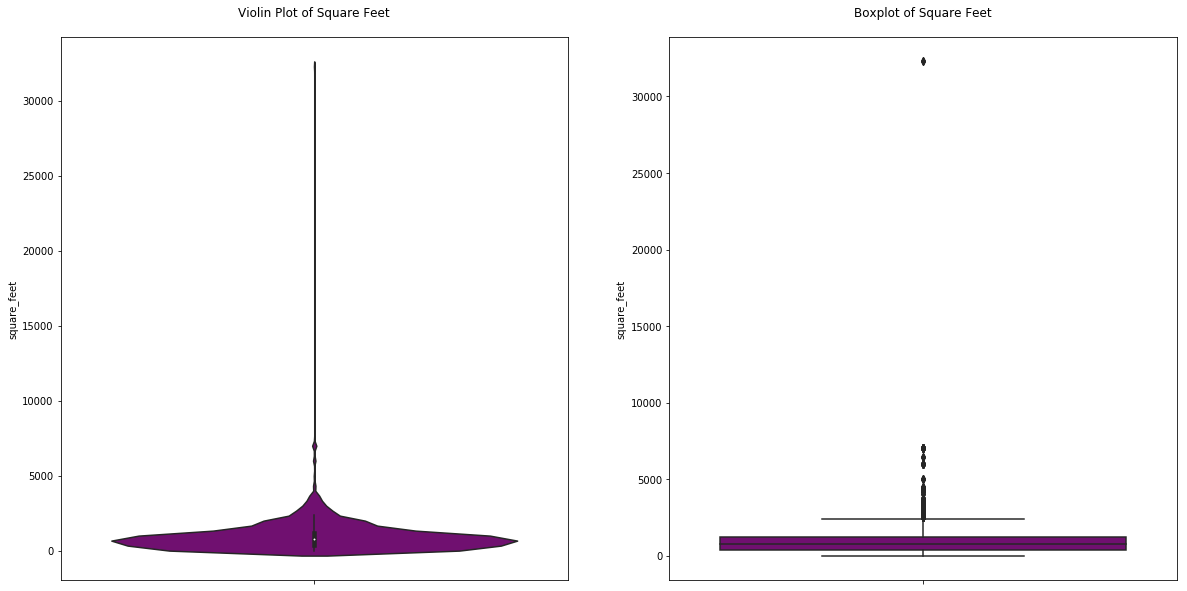

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
ax = sns.violinplot(y=square_feet, ax=axes[0], color="purple")
ax.set(title="Violin Plot of Square Feet")

ax = sns.boxplot(y=square_feet, ax=axes[1], color="purple")
ax.set(title="Boxplot of Square Feet")

plt.show()

### Property Type

Looking at the many different categories in the `property_type` feature, it's clear that the vast majority of listings are of type "house" or "apartment". On the map, the distribution of these two types are plotted along with all other categories grouped together as "other". The map shows how apartments and houses greatly outnumber the listings in the "other" category, but all categories appear to be distributed rather equally across the city.

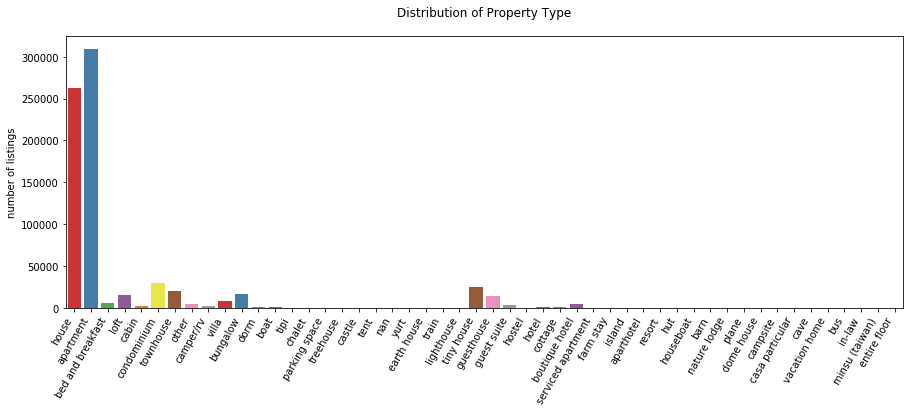

In [16]:
fig, axes = plt.subplots(figsize=(15,5))
ax = sns.countplot(x=property_type, palette="Set1")
ax.set(title="Distribution of Property Type", xlabel="", ylabel="number of listings")
ax.set_xticklabels(labels=property_type.unique(), rotation=60, ha="right")
plt.show()

map from: http://boundaries.latimes.com/set/zip-code-tabulation-areas-2012/

In [17]:
fig, ax = plt.subplots(figsize=(30,30))
base = geo_df.plot(color="lightgray", edgecolor="gray", ax=ax)

geo_df.apply(lambda x: ax.annotate(s=x.external_id,
                                       xy=x.geometry.centroid.coords[0],
                                       ha="center", fontweight="light",
                                       fontsize=12, color="black"), axis=1)
base.axis("off")

# computer will only plot a certain number of points
listing_random = listing_df.sample(n=30000, replace=False, axis=0, random_state=SEED)
listing_random = listing_random[listing_random.property_type.notnull()]
listing_random.plot(ax=base, cmap="prism", marker="o", markersize=3,
                alpha=.8, column="property_type",
                categorical=True, legend=True)

ax.set_xlim([-118.6, -118])
ax.set_ylim([33.9, 34.2])

legend = ax.get_legend()
legend.set_bbox_to_anchor((0.1, 0.1, 0.20, 0.20))

plt.rcParams['axes.titlepad'] = 20 
plt.title("Airbnb Listings in Los Angeles, CA by Property Type", fontdict={"fontsize":35})

plt.savefig('property_type_map.png')
plt.close()

<img src='property_type_map.png'> 

### Feature Importances

I briefly prepared a subset of the data for the random forests training by selecting only the numeric data types in the dataframe. To get rid of any null values (none should have been left after the data cleaning process, but I did this for good measure), I used the pandas interpolate function to fill in the values linearly. Then, I trained a RandomForestRegressor classifier on the data and plotted the features by their importances.

The random forest found the most important features to be number of people accommodated, location (longitude, latitude, zip code), the cost of extra people, room type, and the number of reviews. It's important to note, however, that this was a very simplistic first-pass at the data, and that the feature importance algorithm for random forests [shows some bias towards continuous features or high-cardinality categorical variables](https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e). I re-used this method in my further analysis to pare down the data for use in the final model.

In [18]:
df = pd.read_csv(directory + 'df_clean.csv', nrows=250000)

In [19]:
feat_imp = df.select_dtypes(include=['number'])
feat_imp.interpolate(method='linear', axis=1, inplace=True)

In [20]:
# random forests for feature selection
X = feat_imp.drop(['price_USD'], axis=1)
y = feat_imp.price_USD

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=SEED)

rf = RandomForestRegressor(n_estimators=500,
                           max_depth=5,
                           n_jobs=-1,
                           random_state=SEED)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

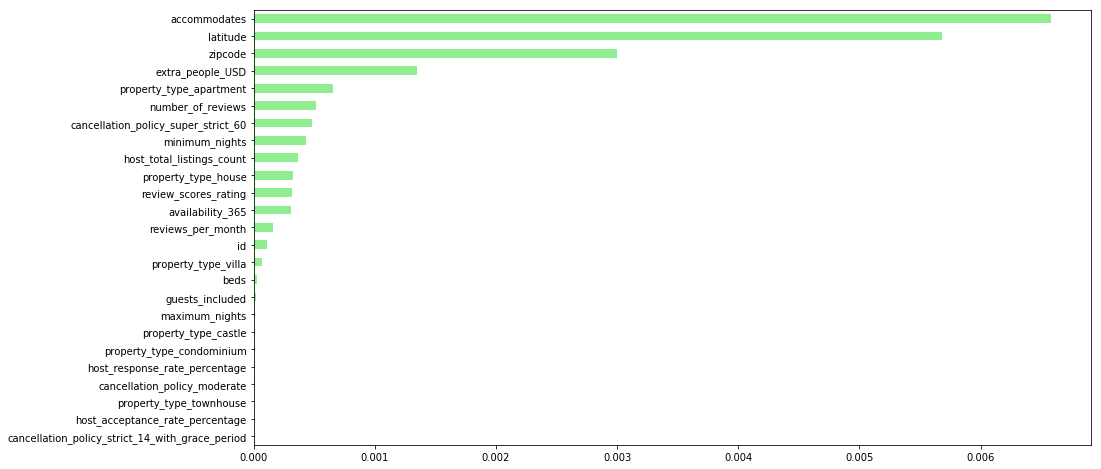

In [21]:
importances_rf = pd.Series(rf.feature_importances_, index = X.columns)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf = sorted_importances_rf[sorted_importances_rf > 0]

fig, ax = plt.subplots(figsize=(15,8))
sorted_importances_rf[0:25].plot(kind='barh', color='lightgreen')
plt.show()